In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
df=pd.read_csv("spam.csv",encoding="latin-1")

In [31]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [32]:
df.shape

(5572, 5)

**1. Data Cleaning**

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [34]:
df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],inplace=True)

In [35]:
df.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [36]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [37]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

In [41]:
#spam:1 ham:0
df['target']= encoder.fit_transform(df['target'])

In [42]:
df.head(5)

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [43]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [44]:
df.duplicated().sum()

np.int64(403)

In [45]:
df=df.drop_duplicates(keep='first')

In [46]:
df.shape

(5169, 2)

**2. EDA**

In [47]:
df.target.value_counts()

target
0    4516
1     653
Name: count, dtype: int64

<Axes: ylabel='target'>

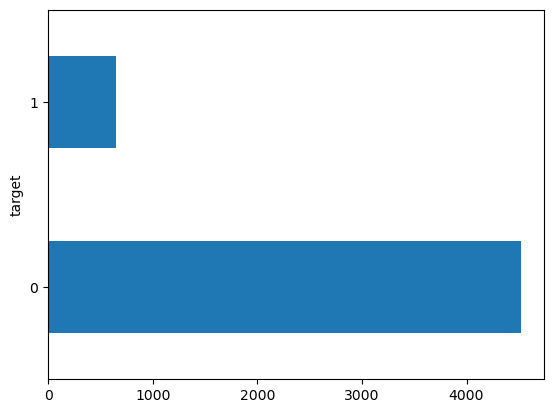

In [48]:
df.target.value_counts().plot.barh()

In [49]:
import nltk

In [50]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/anushriyachettri/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [51]:
df['num_char']=df['text'].apply(len)

In [52]:
df['num_words']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [53]:
df['num_sent']=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [54]:
df.head()

,target,text,num_char,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [55]:
#ham
df[df['target']==0][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
#spam
df[df['target']==1][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [57]:
import seaborn as sns

<Axes: xlabel='num_char', ylabel='Count'>

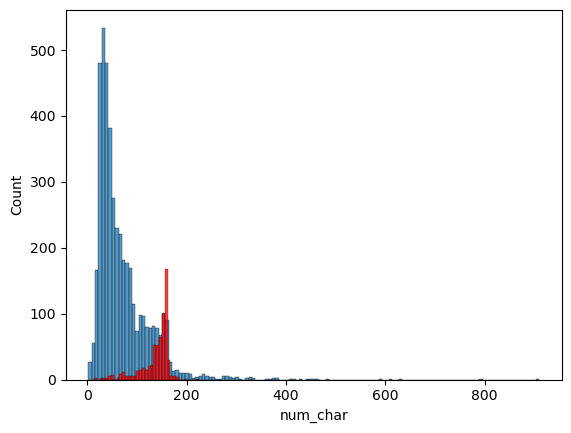

In [60]:
sns.histplot(df[df['target']==0]['num_char'])
sns.histplot(df[df['target']==1]['num_char'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

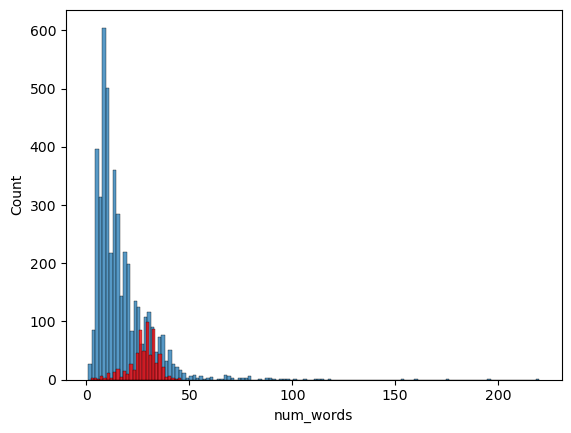

In [61]:
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'],color='red')

<Axes: xlabel='num_sent', ylabel='Count'>

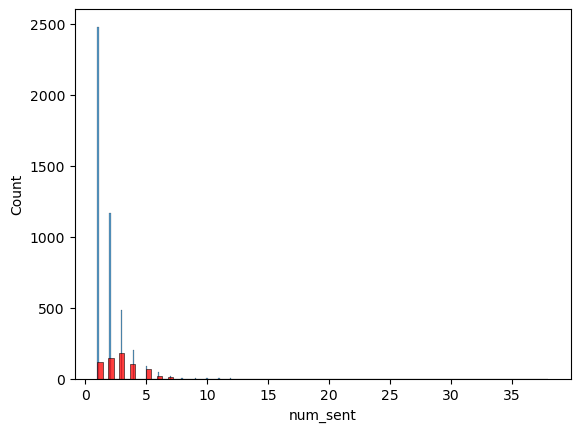

In [62]:
sns.histplot(df[df['target']==0]['num_sent'])
sns.histplot(df[df['target']==1]['num_sent'],color='red')

<Axes: >

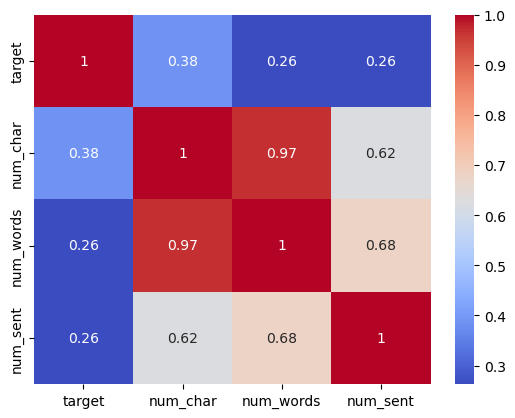

In [68]:
#correlation matrix
sns.heatmap(df[['target','num_char','num_words','num_sent']].corr(),annot=True,cmap='coolwarm')

**3. Text Preprocessing**

In [97]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import re
def text_transform(text):
    #lowercase
    text=text.lower()
    #tokenization
    text=nltk.word_tokenize(text)
    #removing special characters
    y=[]
    for word in text:
        word=re.sub(r'[^a-zA-Z0-9\s]','',word)
        if word:
            y.append(word)
    text=y[:]
    y.clear()
    #removing stopwords and punctuation
    for word in text:
        if word not in stopwords.words('english') and word not in string.punctuation:
            y.append(word)
    text=y[:]
    y.clear()
    #Stemming
    ps=PorterStemmer()
    for word in text:
        y.append(ps.stem(word))
    
    return " ".join(y)
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anushriyachettri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
text="I am dancing Today, I am loving it"
text_transform(text)

'danc today love'

In [102]:
df['transformed_text']=df['text'].apply(text_transform)

In [103]:
df.head()

,target,text,num_char,num_words,num_sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [116]:
from wordcloud import WordCloud
wc=WordCloud(width=1000,height=500,min_font_size=10,background_color='white')

In [117]:
spam_wc=wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))

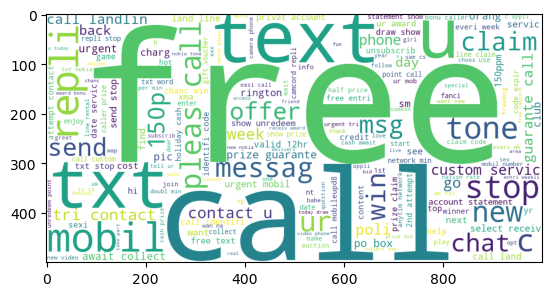

In [118]:
plt.imshow(spam_wc)

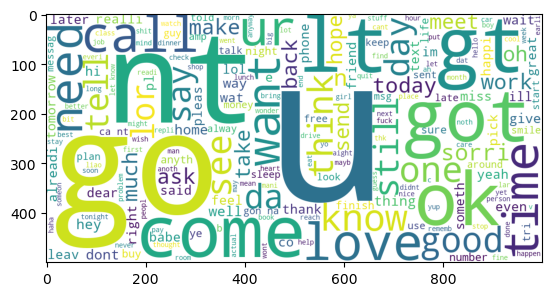

In [119]:
ham_wc=wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc)

**Feature Extraction and Modeling**

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    df['transformed_text'], 
    df['target'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['target']
)

In [143]:
#TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

**Support Vector Machine**

In [150]:
svm_model = SVC(kernel='sigmoid', gamma=1.0, class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

Accuracy: 0.9671179883945842

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       903
           1       0.85      0.90      0.87       131

    accuracy                           0.97      1034
   macro avg       0.92      0.94      0.93      1034
weighted avg       0.97      0.97      0.97      1034



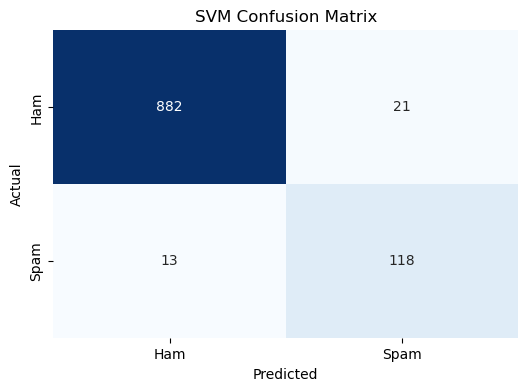

In [151]:
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])
plt.show()

**Multinomial Naive Bayes**

In [152]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
y_pred_mnb=mnb.predict(X_test_tfidf)

Accuracy: 0.971953578336557

Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       903
           1       0.98      0.79      0.88       131

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034



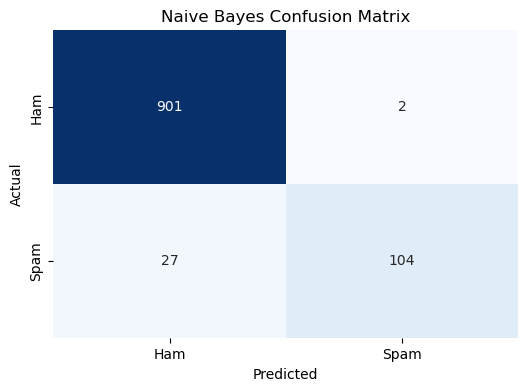

In [154]:
print("Accuracy:", accuracy_score(y_test, y_pred_mnb))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_mnb))

cm = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])
plt.show()